Juuso Eronen, Alex Hall, Jacob 

# In-Class Assignment:  Election Model
<img src="https://blog.udemy.com/wp-content/uploads/2014/06/bigstock-American-Election-43526572.jpg"><p style="text-align: right;">
Image from https://blog.udemy.com/democrats-vs-republicans/
</p>

### Agenda for today's class (110 minutes)

</p>

1. (20 minutes) Review of pre-class assignment and the red/blue state map
1. (20 minutes) The road so far
1. (20 minutes) Modeling the presidential election 
1. (20 minutes) A first Model (polls only)
1. (20 minutes) Randomness
1. (10 minutes) Homework 4 (Eleciton Model)


----
## 1. Review of Pre-Class Assignment and the red/blue state map

---
## 2. The road so far

This semester we've covered the following modeling ideas:
</p>
1. Linear model: Principal Component Analysis
1. Graph/network-based model: PageRank
1. Time series modeling: FFT extrapolation
1. Population modeling: Agent Based Model

</p>
For each type of model we covered  some examples (e.g, iris data, eigen/faces in the wild, MSU network, textRank, NOAA surface temperature estimation, ant foraging) and we were able to make modest predictions. At this point, it is worth stepping back for a second and think about what we are doing as part of a unifying theme. 

In each one of the examples above there was something to be predicted. A set of associated measurements were collected, and simplifying assumptions were made (e.g., temperature is more or less periodic, the space of face images can be recovered with a low dimensional representation, the importance of a web-page is given by its connectivity, etc). The measurements were interpreted through a mathematical abstraction (e.g., a graph, the Fourier transform) and said abstractions were realized in the computer via python code (using libraries such as scikit-learn, urlib and networkx). These computational realizations were tested, quantified (e.g., with mean squared error) and visualized.

However: 
<img src= http://image.slidesharecdn.com/1morris-160225133314/95/environment-and-health-impact-assessment-an-ecological-public-health-aproach-8-638.jpg?cb=1456407241>

&#9989; Do This: As a group, please reflect and discuss Phelman's statement and record your thoughts below and share with the class.

 Models are based on assumptions, which are derived from empirical results which might properly mirror a phenomenon while not really taking everything into account. The degree of accuracy of the model is related to the assumptions that are made. 

Our world is increasingly directed by predictive models: your credit score (which some employers use to assess potential candidates), natural disaster management (e.g., should people evacuate?), insurance premiums, high frequency trading, university admissions, crime forecasts, smart utility grids, potential terrorist identification, etc. Since all models are essentially wrong, their (miss)use can have potentially dire consequences. 

&#9989; Do This: As a group, please reflect on possible strategies for the responsible use of models.  Record your thoughts below and share with the class.

Overly relying on a small number of predictors (e.g. if an employer was to base decisions strongly on credit score) might not lead to desired outcomes. Significant effects are also possible (e.g. due to poor risk management at Lehman, LTCM and friends).

## 3. Modeling the presidential election 

<img src= https://pbs.twimg.com/media/A7Ery-hCYAAykAw.jpg:large> Nate Silver's FiveThirthyEight prediction results for the 2012 (Romney-Obama) presidential election.

**Election Basics: ** Every four years voters go to the polls (the place to vote, not the survey) to select the next president/vicepresident. Each state tallies the results and  the president is the candidate with more electoral votes: each one of the 50 states has a number of votes (called electoral votes) which add up to 538, and that are assigned to each candidate depending on the results/laws of each  state. To complicate matters further, some states have more electoral votes than others (California 55 vs Montana 3).?

&#9989; Do This: Discuss as a group and propose a model to predict the presidential elections. That is, what variables are you going to measure?, how will you measure them?, how are you going to combine them?, and how will you assess how good your model is.

1. Historical trends
2. Polling data
3. State by state economic climate (e.g. significant changes in employment rates)
4. Influence of neighboring states due to polls closing at different times across the country
5. Proportions of people who vote in each state (and whether economic circumstances affect this)
6. See if the model is deterministic, if not do multiple runs and choose the most common output
7. Consider aggregated predictions of institutions like media companies etc.

Initially the model could be very simple and make some inaccurate assumptions:

- assume all states are winner-take-all), and then gradually improve on it. 
- assume all polls are happening at the same time
- for economic modeling, assume states keep the same party if the rate of change of employment is significant enough in magnitude and positive, and change party if the rate is negative enough for people to be unsatisfied

<img src= http://mediatrackers.org/assets/uploads/2013/09/Silver50for50.jpg>


In 2012 Nate Silver accurately predicted the election results for  50 out of 50 states (http://fivethirtyeight.blogs.nytimes.com/fivethirtyeights-2012-forecast/); over the next couple of classes we will be exploring a similar model. One of the main ingredients is compiling results from publicly available state polls, so let us start there.



## 4. A first model (Polls only)

First, please make sure that the *statemap* module and the files *state_labels2.png*, *pollster-ratings.csv* have been uploaded to the server. The code below defines the class * election * which implements and visualizes an election forecast model based on the polling data downloaded from http://www.realclearpolitics.com/.

In [ ]:
%matplotlib inline

---

## 5. Randomness

Another important element of Nate Silver's model is the idea that polls have errors, so one should report a probability instead of a binary blue/red result. Think of it this way: Given all the polling data, one could run several simulations in which some error is randomly added to the data. For each corrupted poll one would run the model and in the end report the probability of winning as estimated by all these simulations.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, clear_output
import time  

import calendar
import datetime
import urllib.request
import re
import sys
import pickle
import os.path
import scipy.misc

class election():
    '''Class to create and display a state map based on colors.'''
    
    def __init__(self, results = []):
        if results == []:
            results = election.poll()
        self.img =  scipy.misc.imread('state_labels2.png')
        #np.load('state_labels2.npy')
        self.img = self.img[:,:,0]
        self.states = election.stateList()
        self.votes = election.electorate()
        if results != []:
            self.majority_wins(results)
    
    def save_poll(filename=""):
        if filename =="":
            filename=str(datetime.date.today())+".p"
        polldata = election.poll()
        pickle.dump( polldata, open( filename, "wb" ) )
    
    def load_poll(filename=""):
        if filename =="":
            filename=str(datetime.date.today())+".p"
        if(os.path.isfile(fname)):
            polldata= pickle.load( open( filename, "rb" ) )
        return(polldata)
        
    def poll_ratings(fname='pollster-ratings.csv'):
        '''
        From: https://github.com/fivethirtyeight
        indices are as follows:
        0:ID, 1:Pollster, 2:Polls, 3:Live Caller With Cellphones, 4:Internet,
        5:NCPP/AAPOR/Roper, 6:Polls, 7:Simple Average Error, 8:Races Called Correctly,
        9:Advanced Plus-Minus, 10:Predictive Plus-Minus, 11:538 Grade, 
        12:Banned by 538, 13:Mean-Reverted Bias
        '''
        pollster_ratings = {}
        if os.path.isfile(fname):
            f = open(fname,'r')
            for line in f:
                index = 0
                for word in line.split(','):
                    if word=='ID':
                        break
                    if index==1:
                        poll = word
                    if index==7:
                        pollster_ratings[poll]=word
                        break
                    index+=1
        else:
            print("Pollster-rating file not found. Using defaults (10)")
        return pollster_ratings
    
    def poll(default_rating=10):
        all_states={}
        us_state_abbrev = election.getAbbrev()
        pollster_ratings = election.poll_ratings()
        today = datetime.date.today()
        one_day = datetime.timedelta(days=1)

        yesterday = today - one_day
        two_days_back = yesterday - one_day

        get_today =  calendar.month_name[today.month] + " " + str(today.day)
        get_day =  calendar.month_name[yesterday.month] + " " + str(yesterday.day)
        prev_get_day =  calendar.month_name[two_days_back.month] + " " + str(two_days_back.day)

        url_contents = str(urllib.request.urlopen("http://www.realclearpolitics.com/epolls/latest_polls/state/").read())
        for i in range(36):
            first_pos = url_contents.find(get_day)
            second_pos = url_contents.find(prev_get_day)

            while second_pos < 0:
                two_days_back -= one_day
                prev_get_day = calendar.month_name[two_days_back.month] + " " + str(two_days_back.day)
                second_pos = url_contents.find(prev_get_day)

            chunk = first_pos = url_contents[first_pos:second_pos]

            pattern = re.compile('(<a .*?(Clinton \+[\d]{1,2}|Trump \+[\d]{1,2}))')

            bits = re.findall( pattern, chunk )

            for bit in bits:
                new_bit = bit[0].replace( "http:", "" )
                new_bit = new_bit.replace( "https:", "" )
                pattern = re.compile( '([A-Z].*?:)' )
                election_type = re.findall( pattern, new_bit )
                if( election_type[0] == "General Election:" ):
                    election_type = "Gen"
                elif( not election_type[0][:-1] in us_state_abbrev ):
                    election_type = election_type[0][:3]
                    continue
                else:
                    election_type = us_state_abbrev.get(election_type[0][:-1])

                start = bit[0].find("http")
                find_poll = bit[0][start:start+200]
                poll_start = find_poll.find(">")
                poll_end = find_poll.find("<")
                pollster = find_poll[poll_start+1:poll_end]
                
                #Set default error to 10
                poll_err = default_rating
                for each in pollster_ratings:
                    if each.find(pollster) > -1 or pollster.find(each) > -1:
                        poll_err = float(pollster_ratings[each])

                pattern = re.compile( '(class="lp-poll.*?</a>)' )
                bits = re.findall( pattern, bit [0] )
                poll_chunk = bits[0][20:]
                first_pos = poll_chunk.find(">")
                poll_chunk = poll_chunk[first_pos+1:-4]

                split_result = bit[1].split(" ")
                perc1 = bit[0][0:-15].find(">Clinton")
                if perc1 < 0:
                    perc1 = bit[0][0:-15].find(">Trump")
                    scoreT = float(bit[0][perc1+7:perc1+9])
                    scoreC = float(bit[0][perc1+19:perc1+21])
                else:
                    scoreT = float(bit[0][perc1+19:perc1+21])
                    scoreC = float(bit[0][perc1+9:perc1+11])


                result = split_result[0][:2] + split_result[1]

                my_date = get_day[len(get_day)-2:len(get_day)]
                if my_date[0] == ' ':
                    my_date = '0' + my_date[1:3]

                if election_type not in all_states:
                    all_states[election_type] = (scoreC, scoreT, (time.strptime(get_day,"%B %d")).tm_yday,poll_err)          

            yesterday -= one_day
            two_days_back -= one_day

            get_day = calendar.month_name[yesterday.month] + " " + str(yesterday.day)
            prev_get_day =  calendar.month_name[two_days_back.month] + " " + str(two_days_back.day)

        return all_states
        
    def getAbbrev():
        us_state_abbrev = {
        'Alabama': 'AL',
        'Alaska': 'AK',
        'Arizona': 'AZ',
        'Arkansas': 'AR',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'District of Columbia': 'DC',
        'Delaware': 'DE',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Hawaii': 'HI',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Iowa': 'IA',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Maine': 'ME',
        'Maryland': 'MD',
        'Massachusetts': 'MA',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Mississippi': 'MS',
        'Missouri': 'MO',
        'Montana': 'MT',
        'Nebraska': 'NE',
        'Nevada': 'NV',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'New York': 'NY',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Pennsylvania': 'PA',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Vermont': 'VT',
        'Virginia': 'VA',
        'Washington': 'WA',
        'West Virginia': 'WV',
        'Wisconsin': 'WI',
        'Wyoming': 'WY',
        }
        return us_state_abbrev
    
    def getnames():
        abbrev = election.getAbbrev()
        names = {}
        for key in abbrev:
            names[abbrev[key]] = key
        return names
    
    #Default eleciton results (used for testing) as randomly picked using out of date polling data.
    def polldefaults():
        defaults = {
            'WA':(1,0),
            'OR':(1,0),
            'CA':(1,0),
            'NV':(1,0),
            'AK':(0,1),
            'ID':(0,1),
            'UT':(0,1),
            'AZ':(0,1),
            'MT':(0,1),
            'WY':(0,1),
            'CO':(1,0),
            'NM':(1,0),
            'HI':(1,0),
            'ND':(0,1),
            'SD':(0,1),
            'NE':(0,1),
            'KS':(0,1),
            'OK':(0,1),
            'TX':(0,1),
            'MN':(1,0),
            'IA':(1,0),
            'MO':(0,1),
            'AR':(0,1),
            'LA':(0,1),
            'WI':(1,0),
            'IL':(1,0),
            'MS':(0,1),
            'IN':(0,1),
            'KY':(0,1),
            'TN':(0,1),
            'AL':(0,1),
            'MI':(1,0),
            'OH':(1,0),
            'GA':(0,1),
            'FL':(1,0),
            'SC':(0,1),
            'NC':(1,0),
            'VA':(1,0),
            'WV':(0,1),
            'MD':(1,0),
            'DE':(1,0),
            'NJ':(1,0),
            'RI':(1,0),
            'MA':(1,0),
            'ME':(1,0),
            'NH':(1,0),
            'VT':(1,0),
            'NY':(1,0),
            'PA':(1,0),
            'CT':(1,0)
        }
        return defaults
    
    def electorate():
        votes = {}
        #Sets of dictionaries to be used with dictionaryLabelStates()
        votes['AL'] = 9
        votes['AK'] = 3
        votes['AZ'] = 11
        votes['AR'] = 6
        votes['CA'] = 55
        votes['CO'] = 9
        votes['CT'] = 7
        votes['DC'] = 3
        votes['DE'] = 3
        votes['FL'] = 29
        votes['GA'] = 16
        votes['HI'] = 4 
        votes['ID'] = 4
        votes['IL'] = 20
        votes['IN'] = 11
        votes['IA'] = 6
        votes['KS'] = 6
        votes['KY'] = 8
        votes['LA'] = 8 
        votes['ME'] = 4
        votes['MD'] = 10 
        votes['MA'] = 11
        votes['MI'] = 16
        votes['MN'] = 10
        votes['MS'] = 6
        votes['MO'] = 10
        votes['MT'] = 3
        votes['NE'] = 5
        votes['NV'] = 6
        votes['NH'] = 4
        votes['NJ'] = 14
        votes['NM'] = 5
        votes['NY'] = 29 
        votes['NC'] = 15
        votes['ND'] = 3
        votes['OH'] = 18
        votes['OK'] = 7
        votes['OR'] = 7
        votes['PA'] = 20
        votes['RI'] = 4
        votes['SC'] = 9
        votes['SD'] = 3
        votes['TN'] = 11
        votes['TX'] = 38
        votes['UT'] = 6
        votes['VT'] = 3
        votes['VA'] = 13
        votes['WA'] = 12
        votes['WV'] = 5
        votes['WI'] = 10
        votes['WY'] = 3
        return votes    
    
    def stateList():
        states ={}
        states['AK']=0
        states['AL']=1
        states['AR']=2
        states['AZ']=3
        states['CA']=4
        states['CO']=5
        states['CT']=6
        states['DC']=7
        states['DE']=8
        states['FL']=9
        states['GA']=10
        states['HI']=11
        states['IA']=12
        states['ID']=13
        states['IL']=14
        states['IN']=15
        states['KS']=16
        states['KY']=17
        states['LA']=18
        states['MA']=19
        states['MD']=20
        states['ME']=21
        states['MI']=22
        states['MN']=23
        states['MO']=24
        states['MS']=25
        states['MT']=26
        states['NC']=27
        states['ND']=28
        states['NE']=29
        states['NH']=30
        states['NJ']=31
        states['NM']=32
        states['NV']=33
        states['NY']=34
        states['OH']=35
        states['OK']=36
        states['OR']=37
        states['PA']=38
        states['RI']=39
        states['SC']=40
        states['SD']=41
        states['TN']=42
        states['TX']=43
        states['UT']=44
        states['VA']=45
        states['VT']=46
        states['WA']=47
        states['WI']=48
        states['WV']=49
        states['WY']=50
        states['border']=255
        return states
   
    def majority_wins(self,results):
        red_blue = np.zeros( (self.img.shape[0], self.img.shape[1], 3) )
        red_blue[self.img > 50,:] = [0.5,0.5,0.5]
        red_blue[self.img < 50,:] = [0.5,0.5,0.5]
        red_blue[self.img == self.states['border'],:] = [1,1,1]
        red = 0
        blue = 0
        for state in election.electorate():
            if state in results:
                polldata = results[state]
                if polldata[0] > polldata[1]:
                    blue = blue + self.votes[state]
                    region = self.states[state]
                    test = self.img == region
                    red_blue[test,:] = [0,0,1]
                elif polldata[1] > polldata[0]:
                    red = red + self.votes[state]
                    region = self.states[state]
                    test = self.img == region
                    red_blue[test,:] = [1,0,0]
                else:                       
                    region = self.states[state]
                    test = self.img == region
                    red_blue[test,:] = [0.5,0.5,0.5]
            else:
                if state in self.states:
                    region = self.states[state]
                    test = self.img == region
                    red_blue[test,:] = [0.5,0.5,0.5]
                        
        plt.figure(figsize = (10,20))
        plt.imshow(red_blue)
        plt.axis('off')
        if(red > 270):
            plt.title("Red Wins: "+str(red)+"/"+str(blue))
        elif(blue > 270):
            plt.title("Blue Wins: "+str(blue)+"/"+str(red))
        else:
            plt.title("No clear winner, Blue: "+str(blue)+" Red:"+str(red)+" --- 270 votes needed")
        return red_blue
    
    def disp_state_movie(self):
        fig, ax = plt.subplots(figsize=(10,5))
        for state in self.states:
            print(state)
            #for region in self.states[state]:
            plt.imshow(self.img == self.states[state])
            plt.title(state)

            # Animaiton part (dosn't change)
            clear_output(wait=True) # Clear output for dynamic display
            display(fig)            # Reset display
            fig.clear()             # Prevent overlapping and layered plots
            time.sleep(2)      # Sleep for a fraction of a second to allow animation to catch up



**After running the cell above**, we read in the latest polling data 


In [2]:
p = election.poll()
print(p)

{'NM': (45.0, 40.0, 300, 10), 'MA': (57.0, 25.0, 300, 10), 'VT': (50.0, 22.0, 299, 10), 'FL': (49.0, 45.0, 307, 10), 'NY': (54.0, 30.0, 292, 5.331666), 'GA': (44.0, 45.0, 307, 10), 'LA': (35.0, 49.0, 303, 6.653334), 'IA': (44.0, 44.0, 300, 4.664438), 'AZ': (40.0, 45.0, 307, 10), 'NC': (47.0, 44.0, 306, 4.664438), 'UT': (31.0, 37.0, 307, 5.488592), 'ID': (29.0, 48.0, 301, 5.29653), 'VA': (41.0, 44.0, 306, 3.48), 'CA': (53.0, 33.0, 307, 3.8568), 'NJ': (51.0, 40.0, 291, 4.077778), 'NH': (39.0, 40.0, 307, 10), 'MT': (27.0, 43.0, 299, 10), 'OR': (43.0, 36.0, 291, 10), 'MO': (37.0, 52.0, 306, 7.877353), 'NV': (43.0, 49.0, 306, 10), 'TX': (40.0, 49.0, 307, 10), 'PA': (47.0, 46.0, 307, 5.804545), 'WI': (46.0, 40.0, 306, 2.594286), 'KY': (37.0, 54.0, 305, 10), 'MI': (47.0, 44.0, 307, 10), 'AR': (31.0, 51.0, 307, 10), 'WA': (53.0, 39.0, 300, 3.988999), 'MN': (49.0, 39.0, 302, 4.62772), 'SD': (35.0, 49.0, 304, 8.509999), 'IN': (39.0, 50.0, 304, 5.488592), 'IL': (53.0, 41.0, 305, 7.877353), 'CO': 

and run the election model with the given data

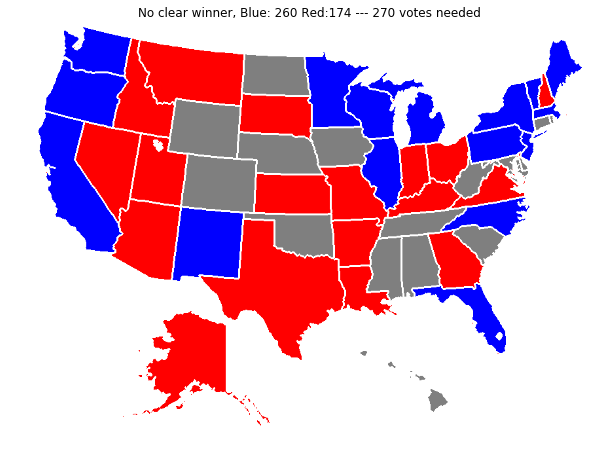

In [3]:
election(p)

&#9989; Do This: Please provide a detailed description of the variable p. That is, what type of variable is it and what information does it contain.

p is a dictionary containing polling data for each state.

---

## 5. Randomness

Another important element of Nate Silver's model is the idea that polls have errors, so one should report a probability instead of a binary blue/red result. Think of it this way: Given all the polling data, one could run several simulations in which some error is randomly added to the data. For each corrupted poll one would run the model and in the end report the probability of winning as estimated by all these simulations.

&#9989; Do This: Write a short program that loops over all of the states.  For each state, predict the election based on the polling data and a normal (gaussian) distribution of error.  You can use the provided "simple error" as the Standard deviation of the sample.

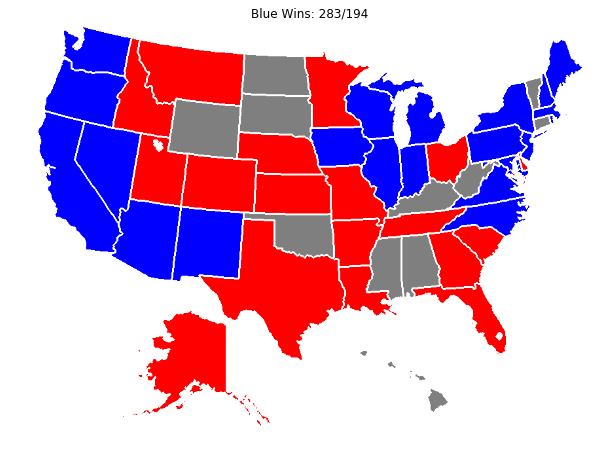

In [17]:
from numpy import random as npr

new_p = {}

for k in p:
    clinton, trump, date, stddev = p[k]
    clinton = npr.normal(clinton, stddev, 1)[0]
    trump = npr.normal(trump, stddev, 1)[0]
    new_p[k] = (clinton, trump, date, stddev)
    
election(new_p)


---

## 6. Homework 4 (Eleciton Model)



---------
### Congratulations, you're done with your in-class assignment!

Now, you just need to submit this assignment by uploading it to the course Desire2Learn web page (Don't forget to add your names in the first cell).  Go to the "in-class assignments" folder, find the dropbox link for "12-Election", and upload it there.

&#169; Copyright 2016,  Michigan State University Board of Trustees